In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np
import seaborn as sns

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines()]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [13]:
df = df.rename(columns={'modelconf.regularizersconf.L1L2_regularizer.l1':'L1','modelconf.regularizersconf.L1L2_regularizer.l2': 'L2'})
df.L1 = df.L1.astype('float64')
df.L2 = df.L2.astype('float64')
df.epoch = df.epoch.astype('uint8')

In [14]:
desc = df[df.epoch > 6].groupby(['L1','L2']).describe()
val_acc = desc['Validation Accuracy'].reset_index().sort_values('50%', ascending=False)
train_acc = desc['Train Accuracy'].reset_index().sort_values('50%', ascending=False)

In [17]:
val_acc[val_acc['50%'] > 0.65]

,L1,L2,count,mean,std,min,25%,50%,75%,max
15,0.00010,0.00100,20.0,0.665286,0.115123,0.534009,0.534009,0.703871,0.748734,0.814761
10,0.00001,0.01000,20.0,0.661740,0.076155,0.534009,0.620658,0.682525,0.727297,0.742764
0,0.00000,0.00000,20.0,0.654794,0.067974,0.544501,0.605011,0.674566,0.703329,0.740593
25,0.01000,0.00001,20.0,0.647377,0.082435,0.534009,0.576610,0.665340,0.697268,0.791245


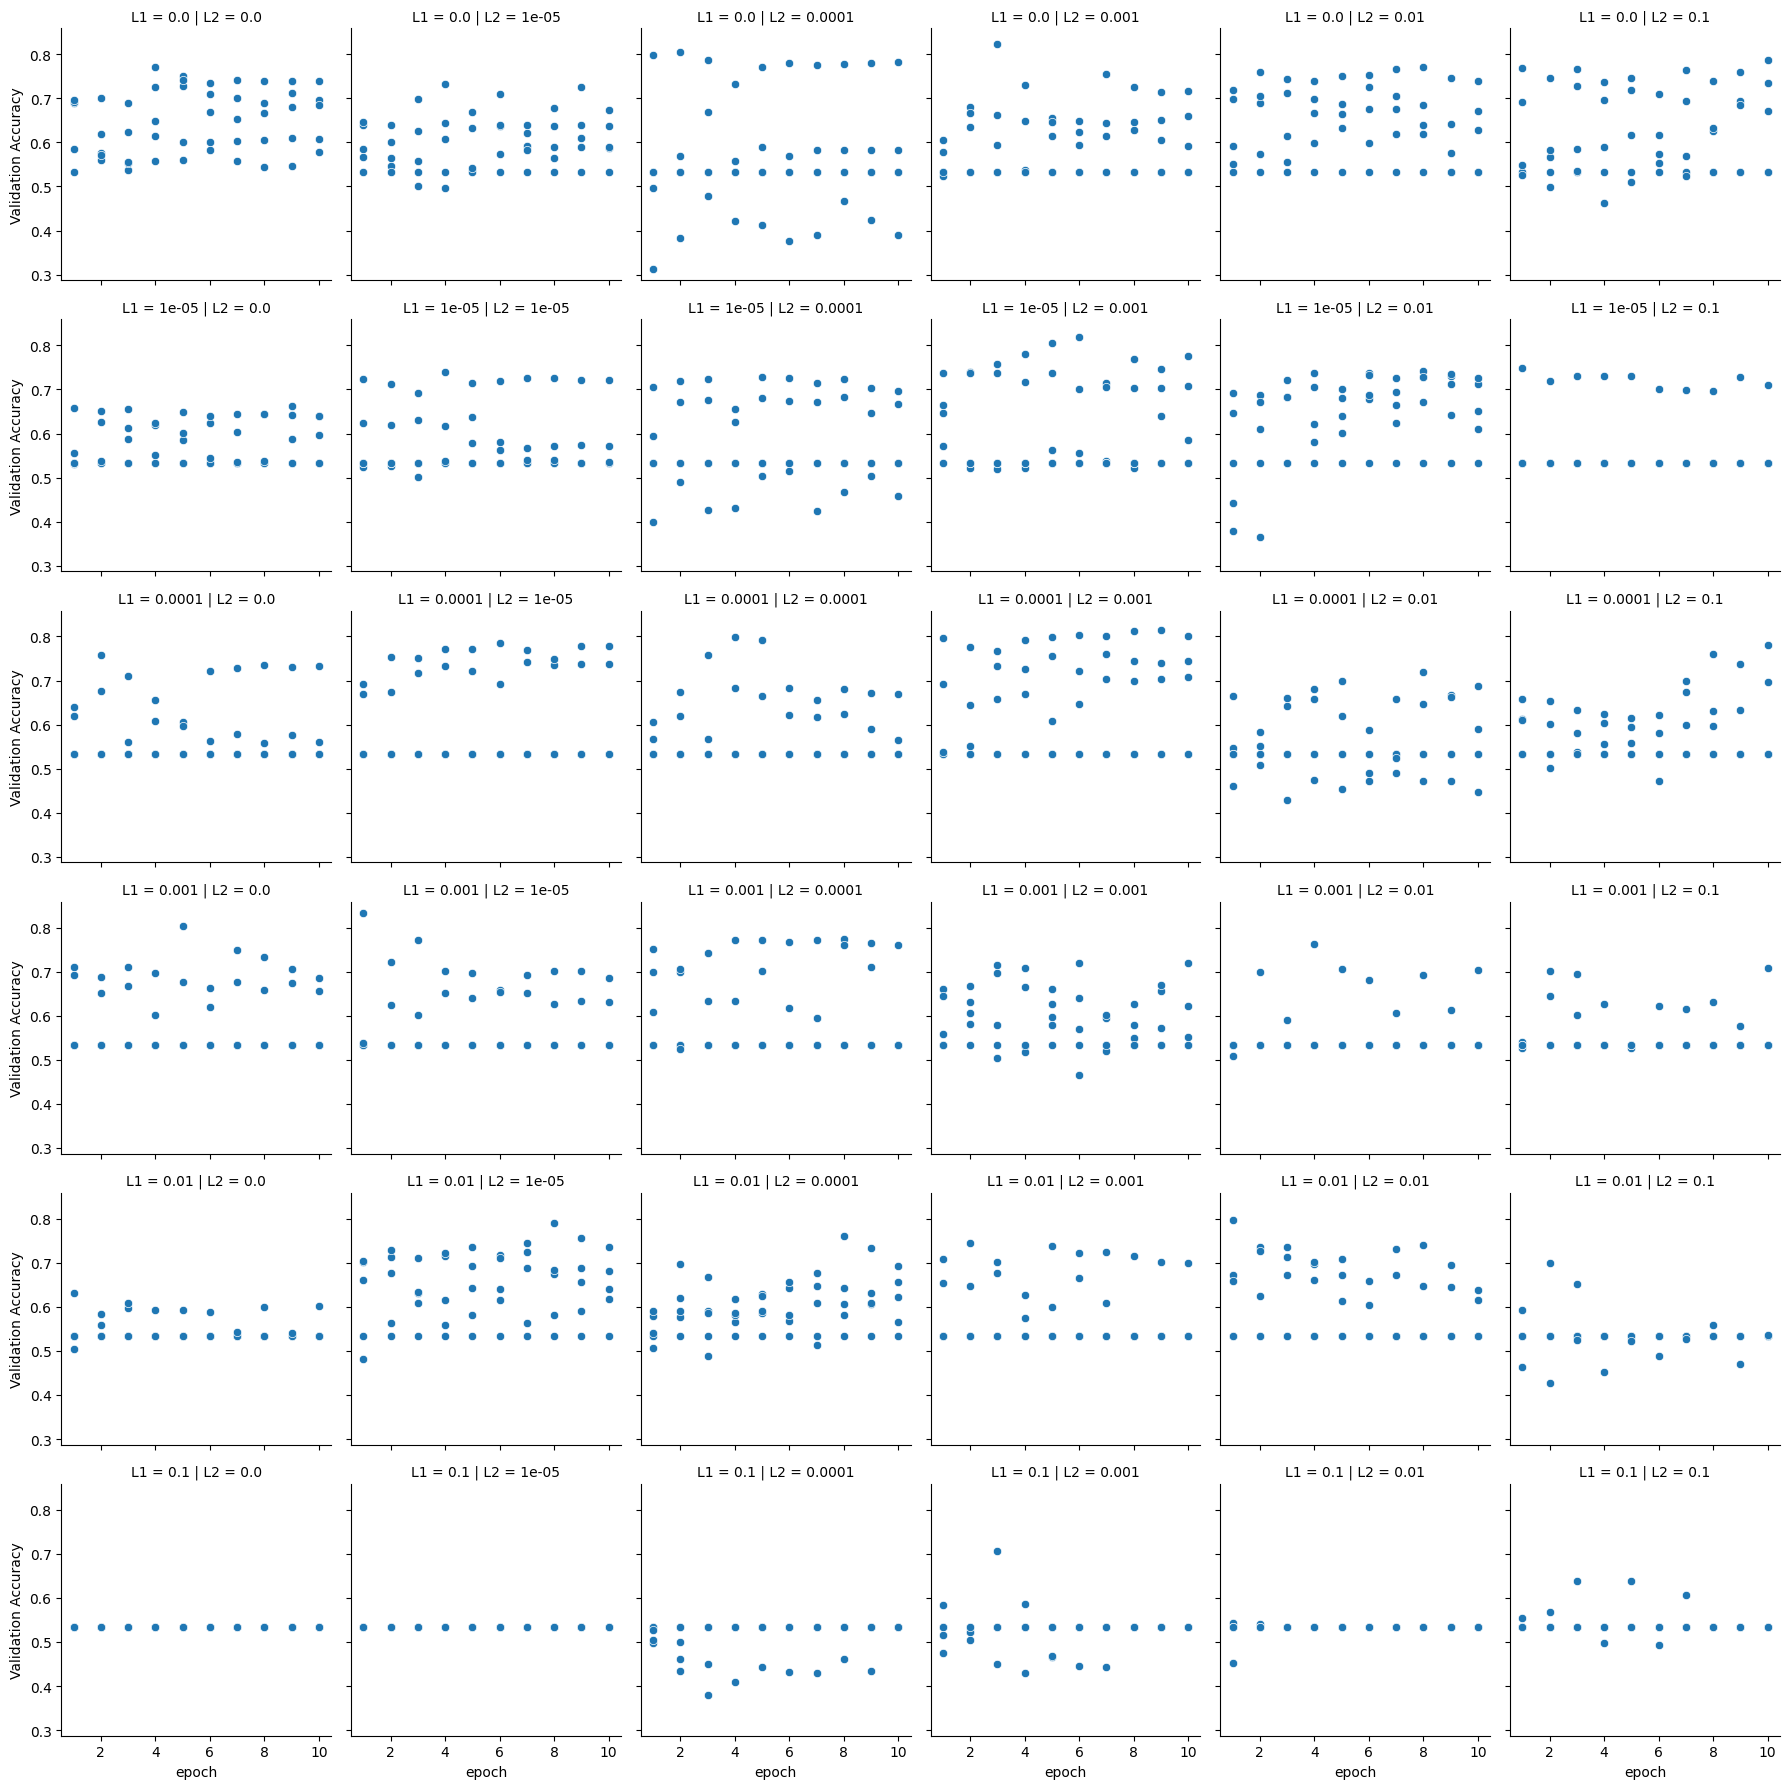

In [16]:
g = sns.FacetGrid(df, row = 'L1', col = 'L2')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()